**`Import necessary libraries`**

In [1]:
import cv2
import sys
import csv
import numpy as np
from kafka import KafkaConsumer
from loguru import logger
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FixedLocator, FixedFormatter
from Encoder_Decoder.receive_and_decode import *

In [2]:
bootstrap_servers = ['127.0.0.1:9093'] #hostname:port, this is the server where we will consume streaming data
topicName = 'metrics' #name of the kafka topic to subsribe to 
offset = 'latest' #offset

**`Create a Kafka Consumer`**  
**`Consumer subsribes to a topic to consume messages as they arrives`**  

In [3]:
consumer = KafkaConsumer(topicName, bootstrap_servers=bootstrap_servers,
                                    auto_offset_reset=offset)

**`Silhouette Score: It is used to choose best value for the numberof clusters`**  
*`An instance's silhouette coefficient is equal to (b-a)/max(b-a)`*  
*`where b is the mean nearest inter cluster distance`*  
*`i.e., the mean distance to the instances of the next closest cluster`*  
*` a is the mean intra cluster distance i.e., the mean distance to other instances`*  
*`in the same cluster`* 

In [4]:
def plot_silhouette(sample_silhouette_values: np.ndarray, silhouette_avg: float,\
                         frame: np.ndarray, labels: np.ndarray, decoded_centroids: np.ndarray) ->None:
    range_n_clusters=[decoded_centroids.shape[0]]
    for n_clusters in range_n_clusters:
        fig, (ax1) = plt.subplots(1, 1)
        fig.set_size_inches(12, 16)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(frame) + (n_clusters + 1) * 10])
        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            rgb = tuple((np.flip(decoded_centroids[i])).astype(int))
            hex_value = '#{:02x}{:02x}{:02x}'.format(*rgb)
            color=hex_value
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  # 10 for the 0 samples
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    

        # Labeling the clusters
        plt.suptitle(
            "Silhouette analysis",
            fontsize=14,
            fontweight="bold",
        )
        fig.savefig('silhouette.png')

def calculate_silhouette(num_colors, i):
    silhouette_array=np.array([])
    for item in clusters[i]:
        a=((clusters[i]-item)**2).sum(axis=1).mean()
        b_array=np.array([])
        for j in range(num_colors):
            if j==i:
                continue
            else:
                pre=((clusters[j]-item)**2).sum(axis=1).mean()
                b_array=np.append(b_array, pre)
        b=b_array[np.argmin(b_array)]
        silhouette_score=(b-a)/max(b,a)
        silhouette_array=np.append(silhouette_array, silhouette_score)
    return silhouette_array

**`Decode the received frame and perform analysis`**

In [5]:
try:
    for i, message in enumerate(consumer):
        # consume message by subscribing to a Kafka topic
        # and decode the message for further processing
        received_frame = message.value.decode()
        decoded_frame = receive_decode_bytes_to_numpy_array((eval(received_frame)['frame'])).reshape(-1,3)
        decoded_centroids = eval(received_frame)['centroids']
        decoded_centroids = np.array(eval(decoded_centroids))
        distances = ((decoded_frame - decoded_centroids[:, np.newaxis])**2).sum(axis=2)
        labels = np.argmin(distances, axis=0)
        ### UNCOMMENT THIS IF YOU WANT TO TRY OUT STREAMING SILHOUETTE ANALYSIS 
        ### although it is very computationally intensive
        # a single frame is shown in the cell below, 
        # silhouette_scores = silhouette_score(decoded_frame, labels)
        # sample_silhouette = silhouette_samples(decoded_frame, labels)
        # logger.info(f"Number of colors detected: {decoded_centroids.shape[0]}, Silhouette score: {silhouette_scores}")
        # streaming_silhouette(sample_silhouette, silhouette_scores, decoded_frame, labels, decoded_centroids)
        # plt.show()
        logger.info(f"Number of colors detected: {decoded_centroids.shape[0]}")
        with open('./Colors_detected.csv','a') as f:
            csvwriter = csv.writer(f)
            csvwriter.writerow([i, decoded_centroids.shape[0]])


except KeyboardInterrupt:
    logger.info("Streaming interrupted")

2023-06-21 13:02:06.923 | INFO     | __main__:<module>:19 - Number of colors detected: 151
2023-06-21 13:02:12.619 | INFO     | __main__:<module>:19 - Number of colors detected: 151
2023-06-21 13:02:18.414 | INFO     | __main__:<module>:19 - Number of colors detected: 151
2023-06-21 13:02:24.207 | INFO     | __main__:<module>:19 - Number of colors detected: 151
2023-06-21 13:02:29.871 | INFO     | __main__:<module>:26 - Streaming interrupted


**`Calculating silhouette score is very very computationally expensive`**  
**`Try out a single frame by running the cell below`**  

**`Uncomment the cell below to calculate the silhouette`**

In [9]:
clusters = [decoded_frame[labels==i] for i in range(decoded_centroids.shape[0])]

In [ ]:
pool = multiprocessing.Pool()
processes = (pool.apply_async(calculate_silhouette, 
                             args=(decoded_centroids.shape[0],
                                   i, )) for i in range(decoded_centroids.shape[0]))
result = [p.get() for p in processes]
result = np.concatenate(result)


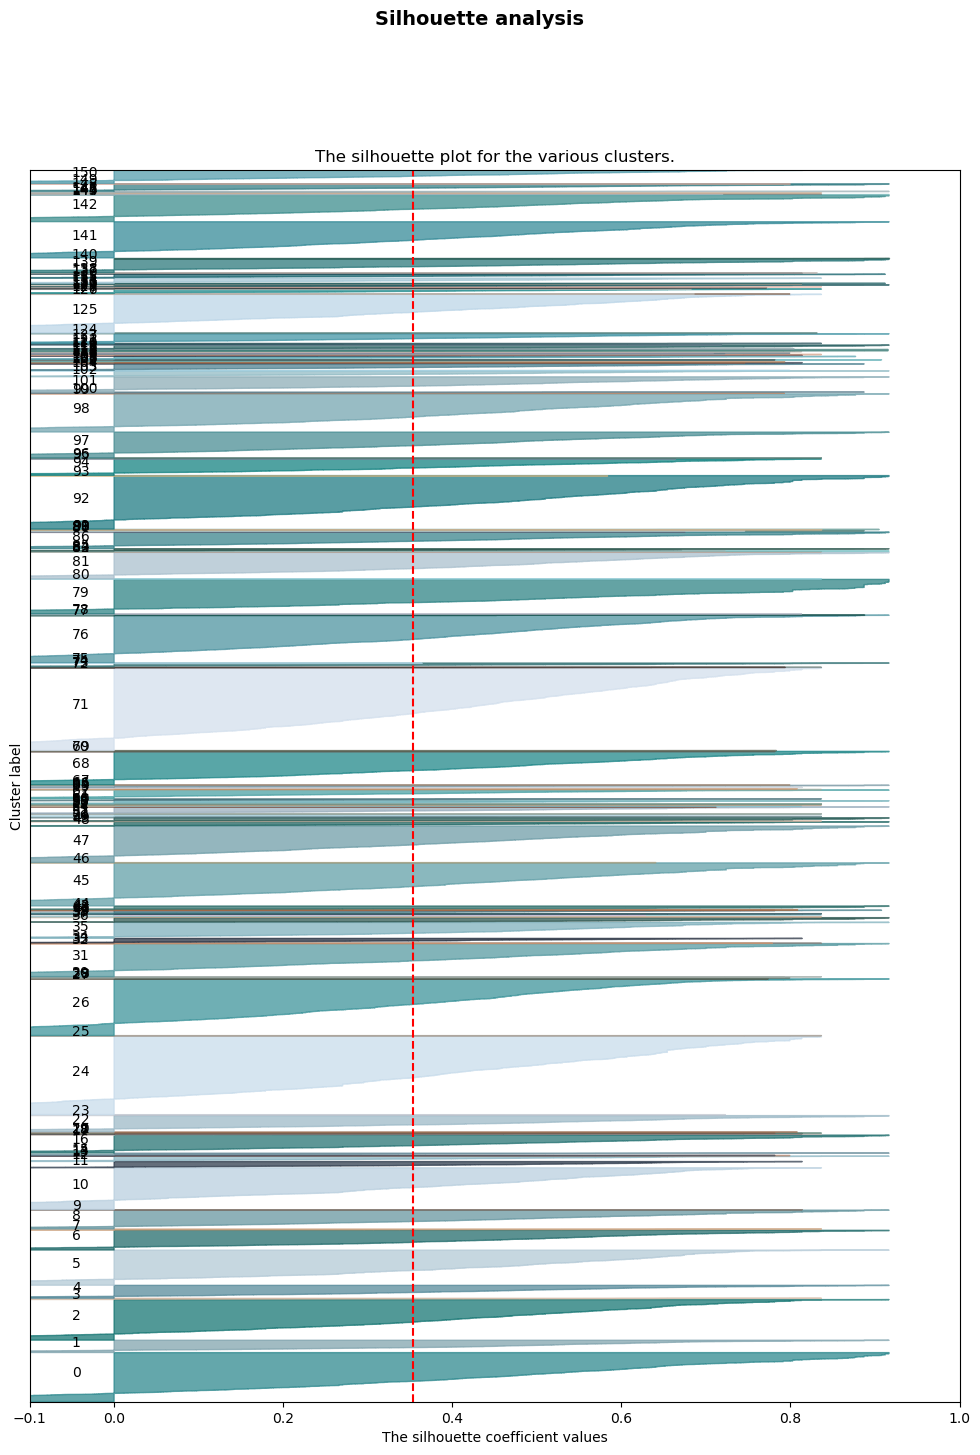

In [14]:
plot_silhouette(result, result.mean(), decoded_frame, labels, decoded_centroids)
plt.show()